# Chapter 6 - Collocates and UFA

This notebook will run through the collocate analysis described in section 6.2.2 of the thesis.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import sys
import os
import json
import itertools
import sqlite3
import regex as re

from datetime import datetime
from collections import Counter

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sys.path.insert(1, "../")
sys.path.insert(1, "../utilities")

from helpers import load_toks
from language_change_methods.ufa import calc_ac1, get_collocates_over_time, coll_lr
from language_change_methods.fluctuation_analysis import fluct_anal, plot_gam_of_series

In [78]:
from settings import TFES_FP as FORUM_DB_FP, TFES_TOK_FP as FORUM_TOKS_FP
from helpers import flat_earth_boards, off_topic_boards as other_boards

sql_get_forum ="""
                SELECT p.uid AS uid, p.time AS time, p.user AS poster_id, b.uid AS board_id
                FROM posts as p
                INNER JOIN topics as t
                ON t.uid = p.topic
                INNER JOIN boards as b
                ON b.uid = t.board;""".strip()

GRAPH_DIR = "./Graphs"

# Load in the data

In [5]:
def read_db(db_fp, query):
    conn = sqlite3.connect(db_fp)
    comments = pd.read_sql_query(query, conn, index_col="uid", parse_dates={"time": "%Y/%m/%d %H:%M:%S"})
    comments.index = comments.index.astype(str)
    comments.sort_values("time", inplace=True)
    return comments


def get_align_toks(tok_fp, posts):
    # Get the corresponding tokens
    toks = {x[0]: x[1] for x in load_toks(tok_fp)}
    toks = pd.Series(toks)
    toks = toks[toks.index.isin(posts.index)]

    # Remove the posts that don't have tokens
    posts = posts[posts.index.isin(toks.index)]
    # Align the ordering of forum posts and toks
    toks = toks.loc[posts.index]

    return toks, posts

In [6]:
%%time
# Gets all flat earth posts
forum_posts = read_db(FORUM_DB_FP, sql_get_forum)

forum_toks, forum_posts = get_align_toks(FORUM_TOKS_FP, forum_posts)

fe_posts = forum_posts.query("board_id in @flat_earth_boards")
ot_posts = forum_posts.query("board_id in @other_boards")

Wall time: 18.6 s


# Some general collocate stuff

In [7]:
%%time
coll_over_time = get_collocates_over_time("earth", fe_posts, forum_toks, 10000, 1000, min_freq=50)

threshold=0
coll_df = coll_over_time.apply(lambda x: x[x > threshold]).fillna(0)
coll_df = coll_df.applymap(lambda x: True if x > 0 else False)

top_colls = coll_over_time.apply(lambda x: x.sort_values(ascending=False).index[:10].values)

for i, colls in top_colls.items():
    print(i.strftime("%Y-%m-%d"), end=",")
    print(",".join(colls))

2013-12-01,flat,round,globe,spherical,shape,society,accelerating,curvature,infinite,surface
2014-01-17,flat,round,spherical,shape,globe,society,accelerating,curvature,surface,disc
2014-03-16,flat,round,globe,spherical,shape,society,accelerating,curvature,disc,model
2014-05-31,flat,round,accelerating,shape,globe,spherical,society,curvature,rotating,model
2014-09-16,flat,round,spherical,shape,accelerating,globe,society,upwards,curvature,disc
2014-12-24,flat,round,spherical,shape,globe,accelerating,society,curvature,disc,proves
2015-02-28,dual,flat,round,spherical,globe,society,shape,accelerating,disc,sphere
2015-04-19,dual,flat,round,spherical,society,shape,globe,accelerating,disc,sphere
2015-07-14,flat,round,spherical,society,shape,globe,accelerating,disc,sphere,model
2015-09-22,flat,round,spherical,society,shape,globe,accelerating,sphere,rotation,disc
2015-12-30,flat,round,spherical,society,shape,globe,accelerating,rotation,sphere,rotating
2016-01-30,flat,round,spherical,society,shape,

In [8]:
%%time
coll_over_time = get_collocates_over_time("round", fe_posts, forum_toks, 10000, 1000, min_freq=10)

threshold=0
coll_df = coll_over_time.apply(lambda x: x[x > threshold]).fillna(0)
coll_df = coll_df.applymap(lambda x: True if x > 0 else False)

top_colls = coll_over_time.apply(lambda x: x.sort_values(ascending=False).index[:10].values)

for i, colls in top_colls.items():
    print(i.strftime("%Y-%m-%d"), end=",")
    print(",".join(colls))

2013-12-01,earthers,earther,earth,model,prove,theory,world,believe,both,is
2014-01-17,earther,earthers,earth,prove,model,assume,theory,world,based,theories
2014-03-16,earther,earthers,earth,assumption,prove,model,assume,planets,theory,based
2014-05-31,earther,earthers,earth,assumption,assume,prove,model,based,theory,planets
2014-09-16,earther,earthers,earth,assumption,prove,assume,model,says,planets,based
2014-12-24,earther,earthers,earth,assumption,perfectly,model,prove,assume,says,based
2015-02-28,earther,earthers,earth,assumption,model,perfectly,assume,says,prove,based
2015-04-19,earther,earthers,earth,assumption,perfectly,model,assume,conspiracy,based,says
2015-07-14,earther,earthers,earth,model,perfectly,planets,prove,conspiracy,thought,based
2015-09-22,earther,earthers,earth,perfectly,planets,model,whether,based,world,thought
2015-12-30,earther,earthers,earth,perfectly,planets,whether,model,based,thought,prove
2016-01-30,earther,earthers,earth,perfectly,whether,planets,model,prov

In [9]:
%%time
coll_over_time = get_collocates_over_time("conspiracy", fe_posts, forum_toks, 10000, 1000, min_freq=10)

threshold=0
coll_df = coll_over_time.apply(lambda x: x[x > threshold]).fillna(0)
coll_df = coll_df.applymap(lambda x: True if x > 0 else False)

top_colls = coll_over_time.apply(lambda x: x.sort_values(ascending=False).index[:10].values)

for i, colls in top_colls.items():
    print(i.strftime("%Y-%m-%d"), end=",")
    print(",".join(colls))

2013-12-01,hide,global,part,theories,theory,shape,nasa,fet,space,evidence
2014-01-17,hide,global,part,theories,theory,shape,fet,nasa,believe,evidence
2014-03-16,hide,global,part,theories,theory,shape,fet,evidence,nasa,space
2014-05-31,hide,global,part,theories,theory,shape,conspiracy,fet,believe,nasa
2014-09-16,theorists,hide,global,part,theories,conspiracy,shape,theory,nasa,space
2014-12-24,theorists,hide,global,part,theories,great,conspiracy,shape,nasa,theory
2015-02-28,theorists,hide,global,part,theories,great,conspiracy,nasa,shape,theory
2015-04-19,hide,global,part,theories,great,conspiracy,nasa,shape,round,theory
2015-07-14,theorists,hide,part,theories,great,conspiracy,nasa,shape,theory,round
2015-09-22,theorists,global,part,theories,great,conspiracy,nasa,shape,theory,world
2015-12-30,theorists,theories,part,great,nasa,theory,world,space,believe,round
2016-01-30,theorists,theories,part,nasa,theory,world,space,round,there,some
2016-02-16,theorists,theories,part,nasa,world,theory,sp

In [10]:
%%time
coll_over_time = get_collocates_over_time("ice", fe_posts, forum_toks, 10000, 1000, min_freq=10)

threshold=0
coll_df = coll_over_time.apply(lambda x: x[x > threshold]).fillna(0)
coll_df = coll_df.applymap(lambda x: True if x > 0 else False)

top_colls = coll_over_time.apply(lambda x: x.sort_values(ascending=False).index[:10].values)

for i, colls in top_colls.items():
    print(i.strftime("%Y-%m-%d"), end=",")
    print(",".join(colls))

2013-12-01,ring,wall,rim,beyond,ice,antarctica,around,an,there,or
2014-01-17,wall,ring,rim,beyond,edge,ice,antarctica,around,an,there
2014-03-16,wall,ring,rim,beyond,edge,ice,antarctica,around,an,there
2014-05-31,wall,ring,rim,beyond,ice,antarctica,around,an,there,or
2014-09-16,wall,ring,rim,beyond,antarctica,ice,around,an,there,or
2014-12-24,wall,ring,rim,beyond,dome,antarctica,edge,around,an,"
2015-02-28,wall,ring,rim,dome,beyond,antarctica,edge,map,around,an
2015-04-19,wall,ring,dome,beyond,ice,edge,antarctica,map,around,an
2015-07-14,wall,border,ring,rim,dome,antarctic,beyond,edge,ice,antarctica
2015-09-22,wall,border,ring,antarctic,dome,beyond,edge,antarctica,map,around
2015-12-30,border,wall,ring,antarctic,dome,beyond,antarctica,map,",an
2016-01-30,border,wall,ring,surrounding,dome,beyond,ice,map,antarctica,"
2016-02-16,shelf,border,wall,ring,surrounding,dome,continent,beyond,antarctica,edge
2016-03-19,shelf,wall,ring,border,walls,surrounding,dome,continent,beyond,antarctica
2016

In [51]:
%%time
coll_over_time = get_collocates_over_time("ice", fe_posts, forum_toks, 10000, 1000, min_freq=None, 
                                          measure=coll_lr, threshold=None, include_counts=True, remove_stops=True)

Wall time: 27.6 s


In [52]:
score_df = coll_over_time.apply(lambda x: x["score"])
coll_count_df = coll_over_time.apply(lambda x: x["coll_freq"])
tota_count_df = coll_over_time.apply(lambda x: x["raw_freq"])

In [53]:
coll_count_df.sum().sort_values(ascending=False).head(10)

wall          14190.0
there          2010.0
earth          1190.0
not            1166.0
ring           1150.0
antarctica     1107.0
flat           1012.0
n't             837.0
ice             820.0
map             756.0
dtype: float64

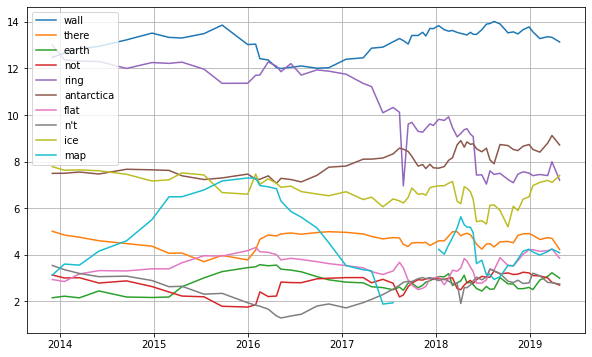

In [54]:
score_df = coll_over_time.apply(lambda x: x["score"])

fig, ax = plt.subplots(figsize=(10,6))
for c in coll_count_df.sum().sort_values(ascending=False).head(10).index:
    curr = score_df[c]
    ax.plot(curr.index, curr.values, label=c)
    
ax.legend()
ax.grid()
plt.show()
    

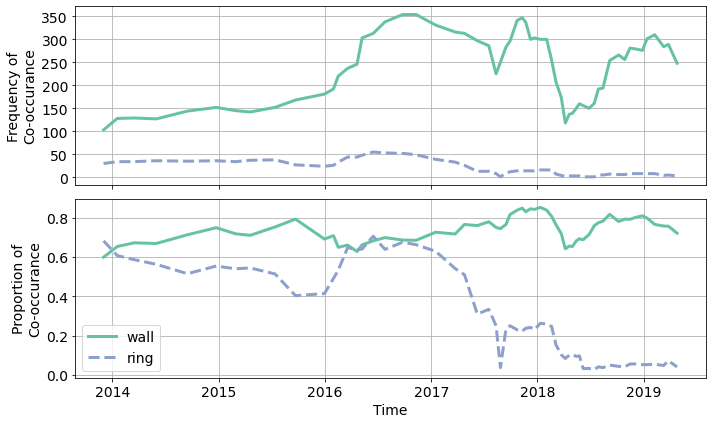

In [79]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,6), sharex=True)
colours=["#66c2a5", "#8da0cb"]
line_styles = ["-", "--"]
for i, c in enumerate(["wall", "ring"]):
    curr = coll_count_df[c]
    ax1.plot(curr.index, curr.values, label=c, lw=3, ls=line_styles[i], c=colours[i])
    curr = (coll_count_df / tota_count_df)[c]
    ax2.plot(curr.index, curr.values, label=c, lw=3, ls=line_styles[i], c=colours[i])
    
ax2.set_xlabel("Time", fontsize=14)
ax2.set_ylabel("Proportion of\nCo-occurance", fontsize=14)
ax1.set_ylabel("Frequency of\nCo-occurance", fontsize=14)
plt.setp(ax2.get_xticklabels(), fontsize=14, rotation=0)
plt.setp(ax2.get_yticklabels(), fontsize=14)
plt.setp(ax1.get_yticklabels(), fontsize=14)
ax2.legend(fontsize=14, loc="lower left")
ax1.grid()
ax2.grid()
plt.tight_layout()
fig.savefig(os.path.join(GRAPH_DIR, "ice_collocates.pdf"))
plt.show()

In [80]:
%%time
coll_over_time = get_collocates_over_time("round", fe_posts, forum_toks, 10000, 1000, min_freq=None, 
                                          measure=coll_lr, threshold=None, include_counts=True, remove_stops=True)

Wall time: 39.7 s


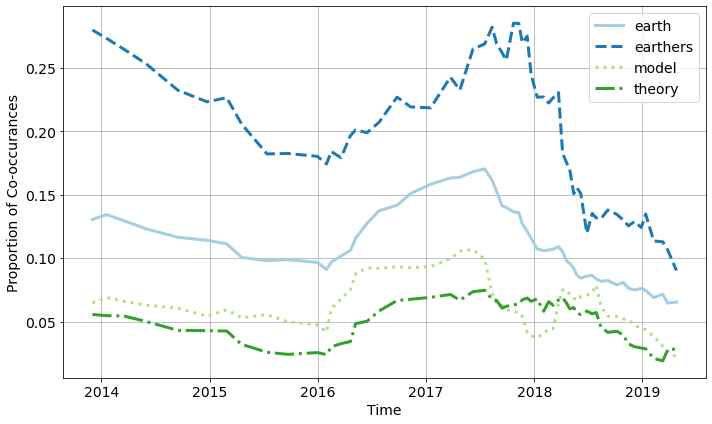

In [91]:
score_df = coll_over_time.apply(lambda x: x["score"])
coll_count_df = coll_over_time.apply(lambda x: x["coll_freq"])
tota_count_df = coll_over_time.apply(lambda x: x["raw_freq"])

colours=["#a6cee3", "#1f78b4", "#b2df8a", "#33a02c"]
line_styles = ["-", "--", ":", "-."]

score_df = coll_over_time.apply(lambda x: x["score"])

fig, ax = plt.subplots(figsize=(10,6))
# for c in coll_count_df.sum().sort_values(ascending=False).head(10).index:
for i, c in enumerate(["earth", "earthers", "model", "theory"]):
    curr = (coll_count_df / tota_count_df)[c]
    ax.plot(curr.index, curr.values, label=c, lw=3, ls=line_styles[i], c=colours[i])
    
ax.set_xlabel("Time", fontsize=14)
ax.set_ylabel("Proportion of Co-occurances", fontsize=14)
plt.setp(ax.get_xticklabels(), fontsize=14, rotation=0)
plt.setp(ax.get_yticklabels(), fontsize=14)
ax.legend(fontsize=14, loc="upper right")
ax.grid()
plt.tight_layout()
fig.savefig(os.path.join(GRAPH_DIR, "round_collocates.pdf"))

plt.show()

In [19]:
%%time
coll_over_time = get_collocates_over_time("flat", fe_posts, forum_toks, 10000, 1000, min_freq=None, 
                                          measure=coll_lr, threshold=None, include_counts=True, remove_stops=True)

Wall time: 1min 7s


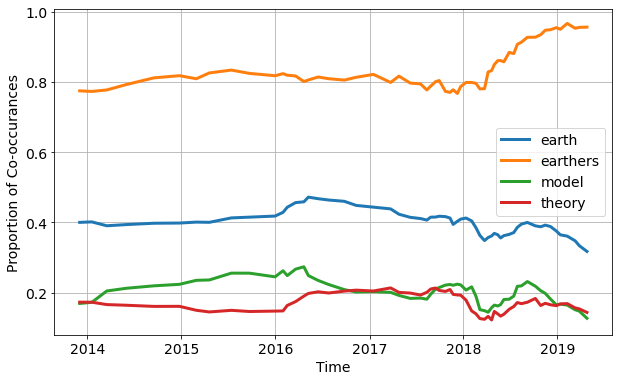

In [20]:
score_df = coll_over_time.apply(lambda x: x["score"])
coll_count_df = coll_over_time.apply(lambda x: x["coll_freq"])
tota_count_df = coll_over_time.apply(lambda x: x["raw_freq"])

score_df = coll_over_time.apply(lambda x: x["score"])

fig, ax = plt.subplots(figsize=(10,6))
for c in ["earth", "earthers", "model", "theory"]:
    curr = (coll_count_df / tota_count_df)[c]
    ax.plot(curr.index, curr.values, label=c, lw=3)
    
ax.set_xlabel("Time", fontsize=14)
ax.set_ylabel("Proportion of Co-occurances", fontsize=14)
plt.setp(ax.get_xticklabels(), fontsize=14, rotation=0)
plt.setp(ax.get_yticklabels(), fontsize=14)
ax.legend(fontsize=14)
ax.grid()

plt.show()

In [21]:
%%time
coll_over_time = get_collocates_over_time("fe", fe_posts, forum_toks, 10000, 1000, min_freq=None, 
                                          measure=coll_lr, threshold=None, include_counts=True, remove_stops=True)

Wall time: 46.2 s


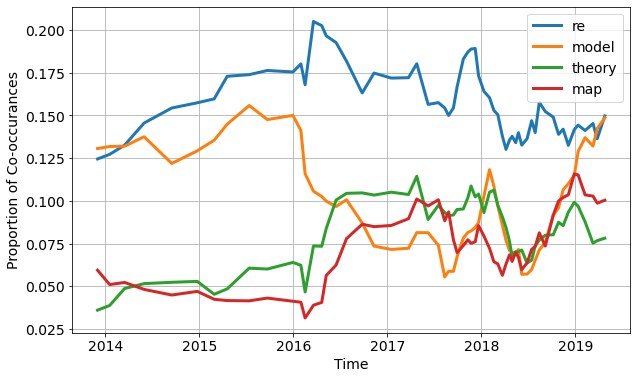

In [22]:
score_df = coll_over_time.apply(lambda x: x["score"])
coll_count_df = coll_over_time.apply(lambda x: x["coll_freq"])
tota_count_df = coll_over_time.apply(lambda x: x["raw_freq"])

score_df = coll_over_time.apply(lambda x: x["score"])

fig, ax = plt.subplots(figsize=(10,6))
# for c in coll_count_df.sum().sort_values(ascending=False).head(10).index:
for c in ["re", "model", "theory", "map"]:
    curr = (coll_count_df / tota_count_df)[c]
    ax.plot(curr.index, curr.values, label=c, lw=3)
    
ax.set_xlabel("Time", fontsize=14)
ax.set_ylabel("Proportion of Co-occurances", fontsize=14)
plt.setp(ax.get_xticklabels(), fontsize=14, rotation=0)
plt.setp(ax.get_yticklabels(), fontsize=14)
ax.legend(fontsize=14)
ax.grid()

plt.show()

In [23]:
%%time
coll_over_time = get_collocates_over_time("believe", fe_posts, forum_toks, 10000, 1000, min_freq=None, 
                                          measure=coll_lr, threshold=None, include_counts=True, remove_stops=True)

Wall time: 39.9 s


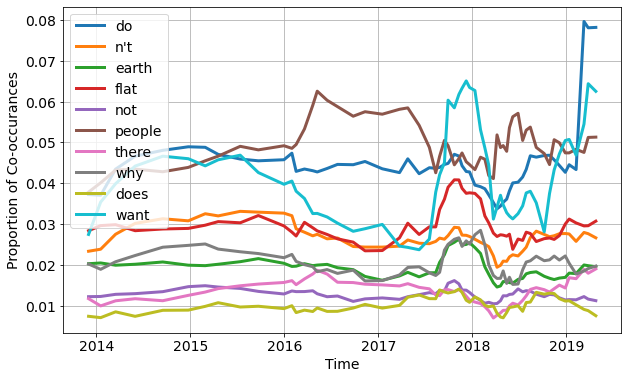

In [24]:
score_df = coll_over_time.apply(lambda x: x["score"])
coll_count_df = coll_over_time.apply(lambda x: x["coll_freq"])
tota_count_df = coll_over_time.apply(lambda x: x["raw_freq"])

score_df = coll_over_time.apply(lambda x: x["score"])

fig, ax = plt.subplots(figsize=(10,6))
for c in coll_count_df.sum().sort_values(ascending=False).head(10).index:
# for c in ["re", "model", "theory", "map"]:
    curr = (coll_count_df / tota_count_df)[c]
    ax.plot(curr.index, curr.values, label=c, lw=3)
    
ax.set_xlabel("Time", fontsize=14)
ax.set_ylabel("Proportion of Co-occurances", fontsize=14)
plt.setp(ax.get_xticklabels(), fontsize=14, rotation=0)
plt.setp(ax.get_yticklabels(), fontsize=14)
ax.legend(fontsize=14)
ax.grid()

plt.show()

In [47]:
%%time
coll_over_time = get_collocates_over_time("plane", fe_posts, forum_toks, 10000, 1000, min_freq=None, 
                                          measure=coll_lr, threshold=None, include_counts=True, remove_stops=True)

Wall time: 32.1 s


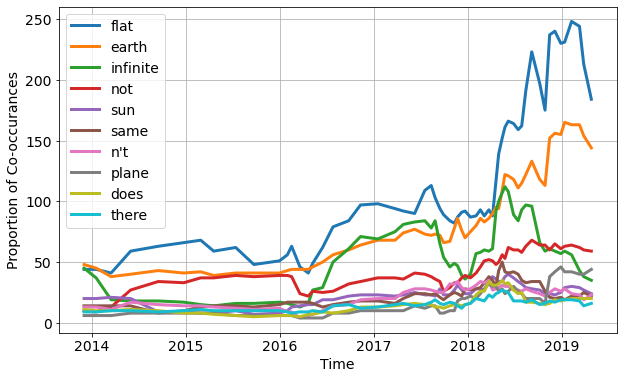

In [50]:
score_df = coll_over_time.apply(lambda x: x["score"])
coll_count_df = coll_over_time.apply(lambda x: x["coll_freq"])
tota_count_df = coll_over_time.apply(lambda x: x["raw_freq"])

score_df = coll_over_time.apply(lambda x: x["score"])

fig, ax = plt.subplots(figsize=(10,6))
for c in coll_count_df.sum().sort_values(ascending=False).head(10).index:
# for c in ["re", "model", "theory", "map"]:
    curr = (coll_count_df / tota_count_df)[c]
    curr = coll_count_df[c]
    ax.plot(curr.index, curr.values, label=c, lw=3)
    
ax.set_xlabel("Time", fontsize=14)
ax.set_ylabel("Proportion of Co-occurances", fontsize=14)
plt.setp(ax.get_xticklabels(), fontsize=14, rotation=0)
plt.setp(ax.get_yticklabels(), fontsize=14)
ax.legend(fontsize=14)
ax.grid()

plt.show()

# UFA

In [25]:
%%time
coll_over_time = get_collocates_over_time("flat", fe_posts, forum_toks, 10000, 1000)

Wall time: 32.7 s


In [26]:
threshold=0
coll_df = coll_over_time.apply(lambda x: x[x > threshold]).fillna(0)
coll_df = coll_df.applymap(lambda x: True if x > 0 else False)
fluct = fluct_anal(coll_df, calc_ac1)

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


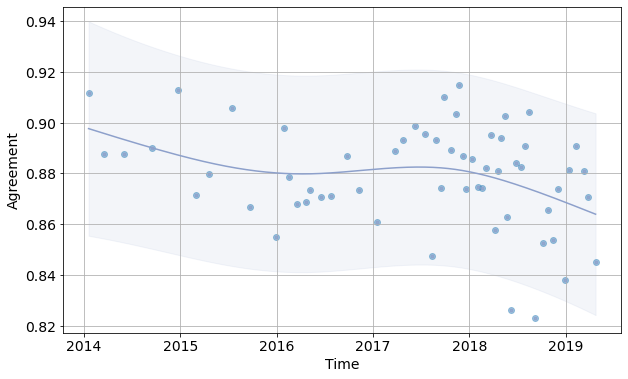

In [27]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(fluct.index, fluct.values, alpha=0.4)

plot_gam_of_series(fluct, ax)

ax.set_xlabel("Time", fontsize=14)
ax.set_ylabel("Agreement", fontsize=14)
plt.setp(ax.get_xticklabels(), fontsize=14, rotation=0)
plt.setp(ax.get_yticklabels(), fontsize=14)

ax.grid()
plt.show()

In [28]:
["flat", "re", "ice", "ua"]

['flat', 're', 'ice', 'ua']

In [86]:
def run_ufa(query, posts, toks, w_size, w_step, min_freq=5, coll_win_size=5, out_fp=None):
    coll_over_time = get_collocates_over_time(query, posts, toks, 10000, 2000, 
                                              min_freq=min_freq, coll_win_size=coll_win_size)
    
    threshold=0
    coll_df = coll_over_time.apply(lambda x: x[x > threshold]).fillna(0)
    coll_df = coll_df.applymap(lambda x: True if x > 0 else False)
    fluct = fluct_anal(coll_df, calc_ac1)
    
    fig, ax = plt.subplots(figsize=(10,6))
    ax.scatter(fluct.index, fluct.values, alpha=0.4)

    plot_gam_of_series(fluct, ax)

    ax.set_xlabel("Time", fontsize=14)
    ax.set_ylabel("Agreement", fontsize=14)
    plt.setp(ax.get_xticklabels(), fontsize=14, rotation=0)
    plt.setp(ax.get_yticklabels(), fontsize=14)

    ax.grid()
    plt.tight_layout()
    if out_fp is not None:
        fig.savefig(out_fp)
        
    plt.show()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


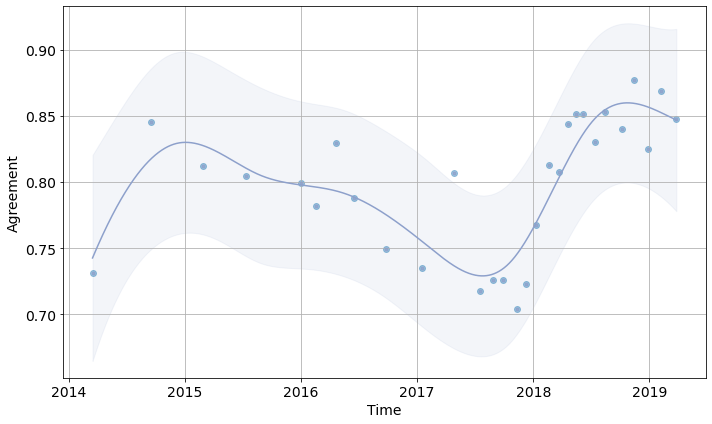

Wall time: 11.3 s


In [87]:
%%time
run_ufa("round", fe_posts, forum_toks, 10000, 1000, min_freq=10, coll_win_size=10, 
        out_fp=os.path.join(GRAPH_DIR, "round_ufa.pdf"))

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


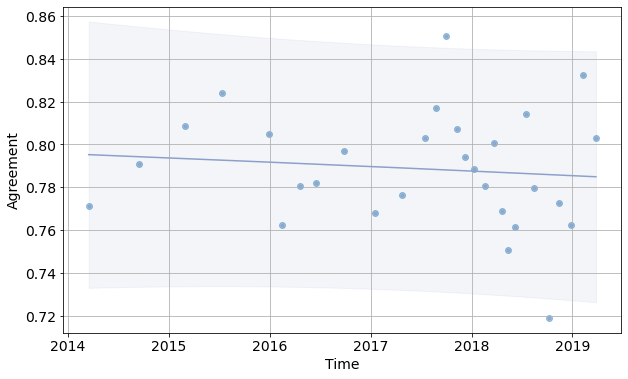

Wall time: 18.5 s


In [31]:
%%time
run_ufa("earth", fe_posts, forum_toks, 10000, 1000, min_freq=10)

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


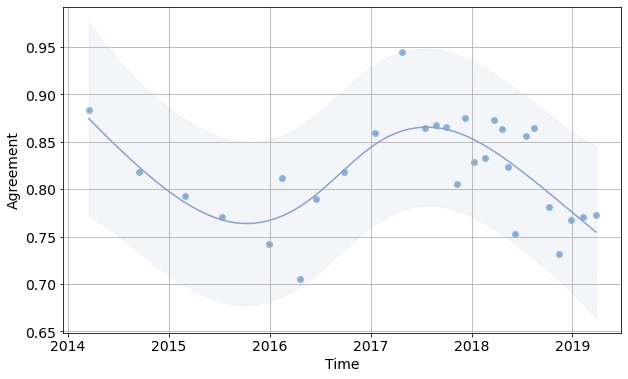

Wall time: 11 s


In [32]:
%%time
run_ufa("globe", fe_posts, forum_toks, 10000, 1000, min_freq=10)

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


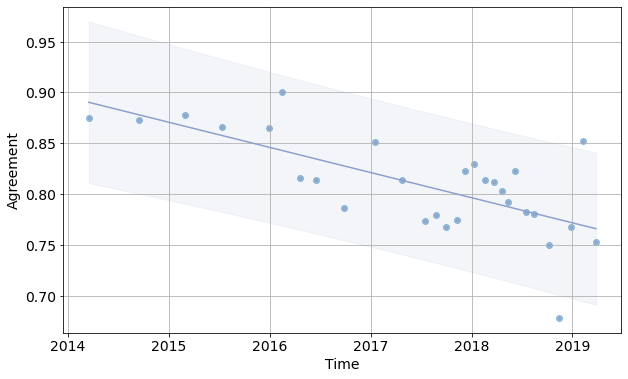

Wall time: 11.6 s


In [33]:
%%time
run_ufa("fe", fe_posts, forum_toks, 10000, 1000, min_freq=10)

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


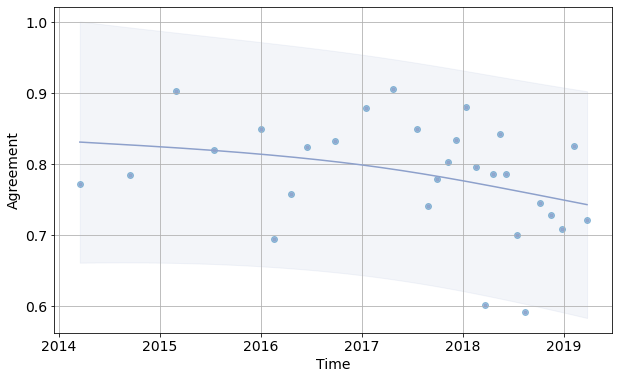

Wall time: 10.5 s


In [34]:
%%time
run_ufa("re", fe_posts, forum_toks, 10000, 1000, min_freq=10)

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


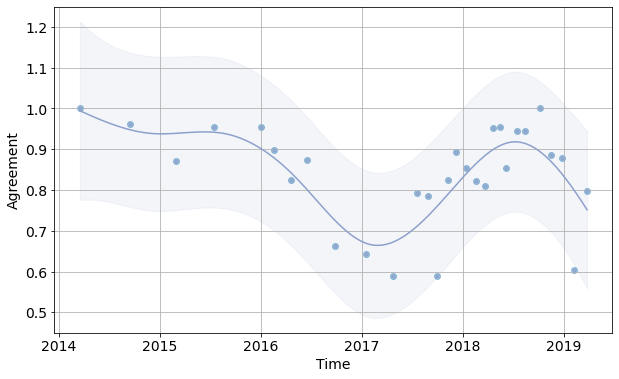

Wall time: 9.77 s


In [35]:
%%time
run_ufa("3d", fe_posts, forum_toks, 10000, 1000, min_freq=10)

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


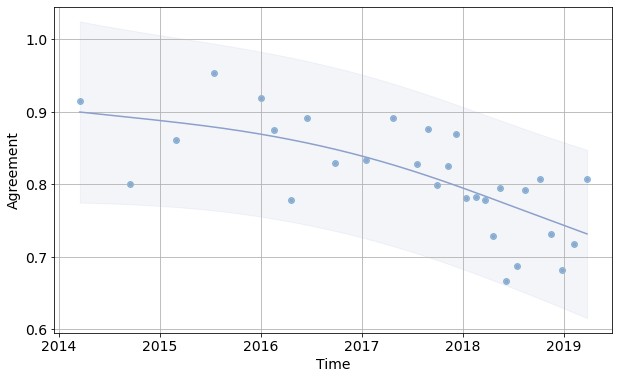

Wall time: 10.5 s


In [36]:
%%time
run_ufa("plane", fe_posts, forum_toks, 10000, 1000, min_freq=10)

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


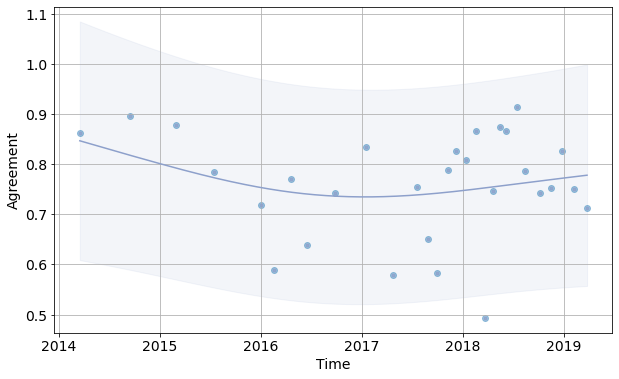

Wall time: 10.3 s


In [37]:
%%time
run_ufa("ice", fe_posts, forum_toks, 10000, 1000, min_freq=10)

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


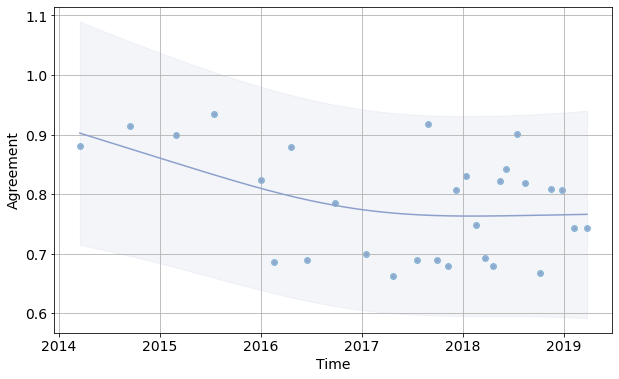

Wall time: 10.4 s


In [38]:
%%time
run_ufa("wall", fe_posts, forum_toks, 10000, 1000, min_freq=10)

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


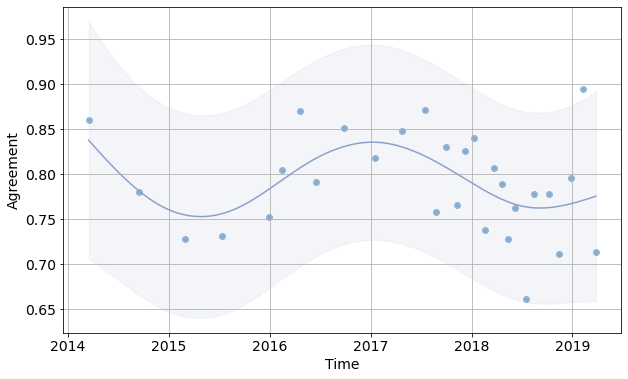

Wall time: 11.5 s


In [39]:
%%time
run_ufa("theory", fe_posts, forum_toks, 10000, 1000, min_freq=10)

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


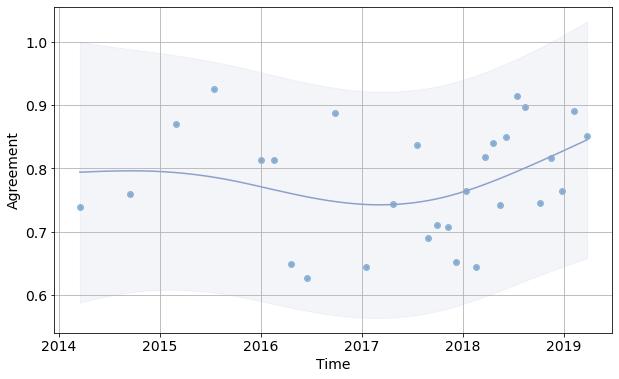

Wall time: 10.4 s


In [40]:
%%time
run_ufa("conspiracy", fe_posts, forum_toks, 10000, 1000, min_freq=10)

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


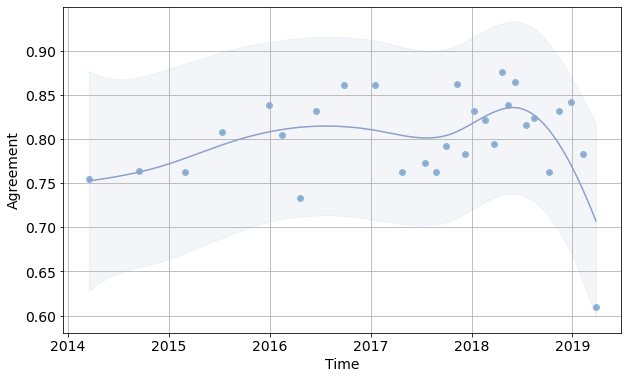

Wall time: 11.1 s


In [41]:
%%time
run_ufa("believe", fe_posts, forum_toks, 10000, 1000, min_freq=10)

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


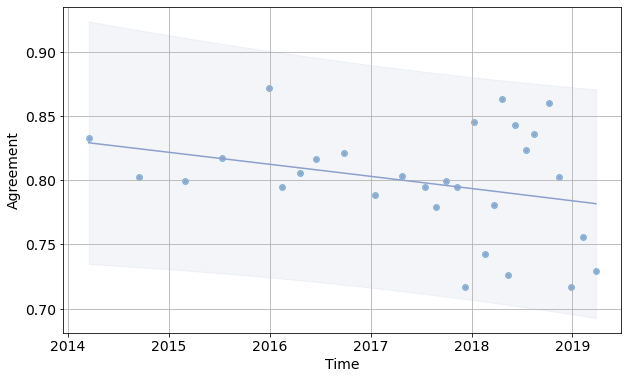

Wall time: 12.5 s


In [42]:
%%time
run_ufa("why", fe_posts, forum_toks, 10000, 1000, min_freq=10)

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


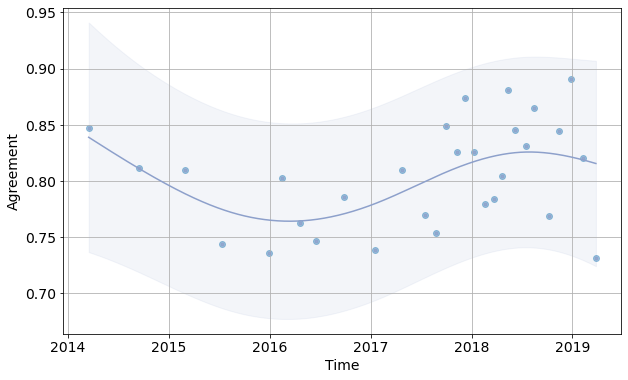

Wall time: 11.5 s


In [43]:
%%time
run_ufa("who", fe_posts, forum_toks, 10000, 1000, min_freq=10)

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


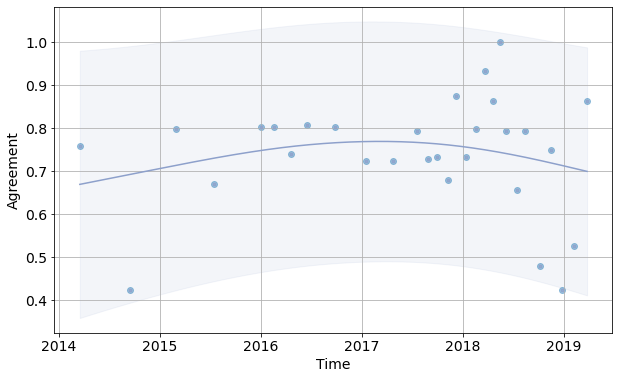

Wall time: 9.79 s


In [46]:
%%time
run_ufa("explaining", fe_posts, forum_toks, 10000, 1000, min_freq=10)

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


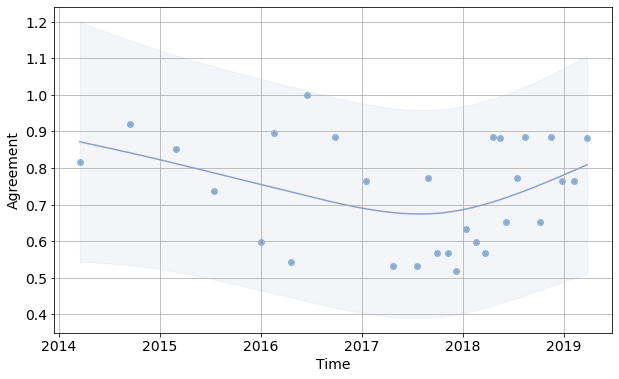

Wall time: 9.76 s


In [45]:
%%time
run_ufa("particularly", fe_posts, forum_toks, 10000, 1000, min_freq=10)